# CVE.ICU - Predictions
---

This information from this website is from a [jupyter notebook](https://jupyter.org/) that automatically pulls all [JSON Data](https://nvd.nist.gov/vuln/data-feeds#JSON_FEED) from the NVD and perform some fundamental data analysis and graphing.  If you have any questions or suggestions, please join the [discussion here](https://github.com/jgamblin/cve.icu/discussions) and check out the [source code](https://github.com/jgamblin/cve.icu/).  Questions? Reach out to [@jgamblin](https://www.twitter.com/jgamblin).

**Yearly Data**
-  [All](https://cve.icu/)
-  [2022](2022.html)
-  [2021](2021.html)
-  [2020](2020.html)
-  [2019](2019.html)

**Other Data**
-  [CVE Growth Predictions](prophet.html)
-  [CVE Calendar All Years](calendar.html)
-  [CNA Map](cnamap.html)

In [1]:
import datetime
import glob
import json
import logging
import sys
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
import os
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot


pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)


# Turn off pystan warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.filterwarnings("ignore")

# Turn off fbprophet stdout logger
logging.getLogger('fbprophet').setLevel(logging.ERROR)
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


In [2]:
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data_JG'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data_JG'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data_JG'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data_JG'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data_JG'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data_JG'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data_JG'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data_JG'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data_JG'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = 'Missing_Data_JG'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data_JG'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data_JG'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data_JG'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data_JG'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description
            }
            if not description.startswith('** REJECT **'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
    nvd = pd.DataFrame(row_accumulator)

nvd['Published'] = pd.to_datetime(nvd['Published'])
years = ((nvd['Published'] > '2017-01-01') & (nvd['Published']  < '2022-12-31'))
nvd = nvd.loc[years]
nvd['Published'] = pd.to_datetime(nvd['Published']).apply(lambda x: x.date())

## Prophet Predictions

This notebookls performs some basic time series forecasting using [Prophet](https://facebook.github.io/prophet/) from Facebook.  

In [3]:
%%capture
orig_out = sys.stdout
sys.stdout = open(os.devnull, 'w')
cve_day = pd.DataFrame(nvd.Published.value_counts().reset_index().values, columns=["ds", "y"]);
cve_day = cve_day.sort_index(axis = 0, ascending=True);
cve_day = cve_day[cve_day['y'] <= 400]; 
m = Prophet();
m.fit(cve_day);
future = m.make_future_dataframe(periods=3650);
forecast = m.predict(future);
by_year = forecast.copy();
result = by_year.groupby(by_year.ds.dt.to_period("Y"))['yhat'].sum().round();
sys.stdout = orig_out

Initial log joint probability = -35.696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2822.38   0.000941084       95.3143           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       2822.93    0.00166611       117.905   1.491e-05       0.001      170  LS failed, Hessian reset 
     189       2823.69   0.000617465       124.286   5.123e-06       0.001      317  LS failed, Hessian reset 
     199       2823.76   4.91038e-05       72.2883      0.3192      0.3192      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       2823.93   3.39363e-07       58.6988           1           1      426   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


### Prediction Per Year

In [4]:
for year, records in result.items():
    print(f"{year} - {records} CVEs")

2017 - 14534.0 CVEs
2018 - 15978.0 CVEs
2019 - 17201.0 CVEs
2020 - 18408.0 CVEs
2021 - 20203.0 CVEs
2022 - 22133.0 CVEs
2023 - 23730.0 CVEs
2024 - 25413.0 CVEs
2025 - 26916.0 CVEs
2026 - 28464.0 CVEs
2027 - 30010.0 CVEs
2028 - 31568.0 CVEs
2029 - 33128.0 CVEs
2030 - 34696.0 CVEs
2031 - 36267.0 CVEs
2032 - 2610.0 CVEs


### Plot the Forecast

This shows the plot for all previous data and the next 10 years. 

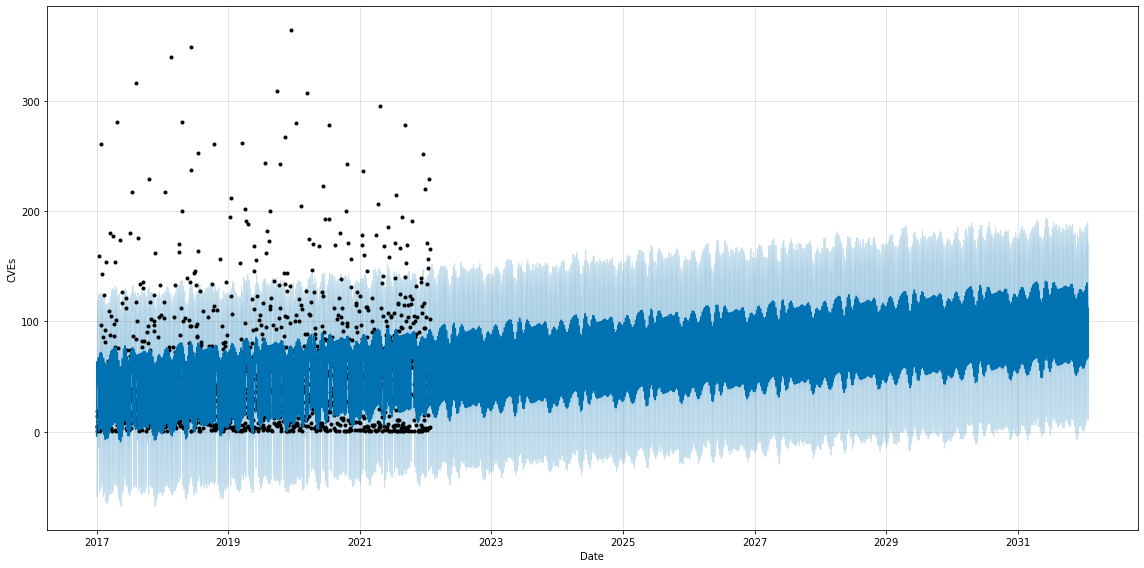

In [5]:

fig = m.plot(forecast, xlabel='Date', ylabel='CVEs', figsize=(16, 8) )

### Plot the Forecast With Change Points

This shows the plot for all previous data and the next 10 years with changepoints marked where the data had abrupt changes in its trajectories.

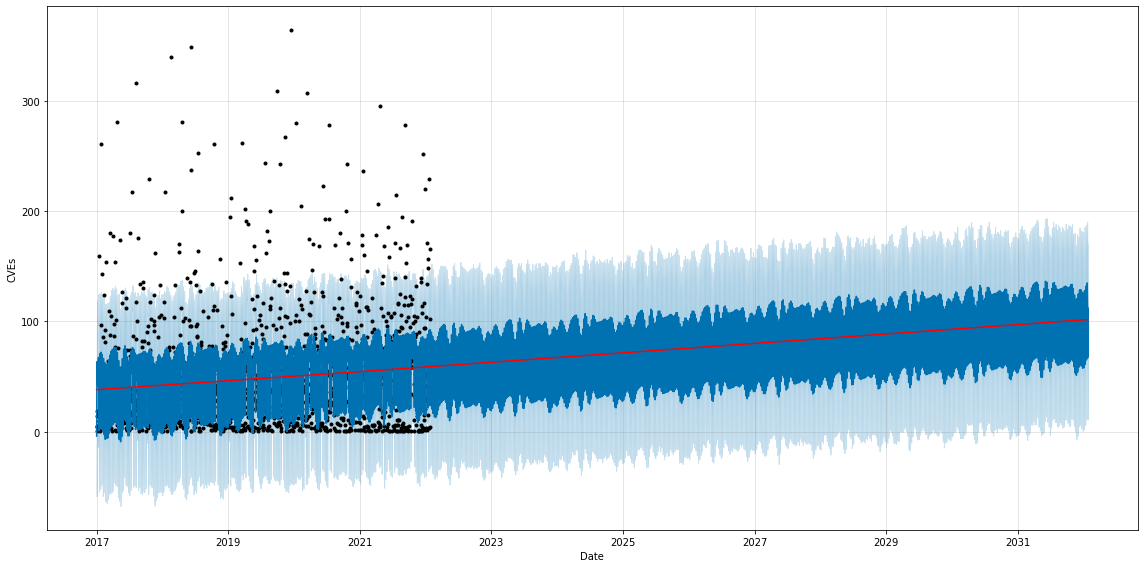

In [6]:
fig = m.plot(forecast, xlabel='Date', ylabel='CVEs', figsize=(16, 8))
a = add_changepoints_to_plot(fig.gca(), m, forecast)

### Most CVE Per Day Predictions For The Next Year

In [7]:
date_now = datetime.now()
one_year = date_now + pd.DateOffset(years=1)
five_year = date_now + pd.DateOffset(years=5)
ten_year = date_now + pd.DateOffset(years=10)


cve_prophet_thisyear = forecast[(forecast['ds'] > date_now) & (forecast['ds'] < one_year)]
cve_prophet_thisyear =  cve_prophet_thisyear[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)
cve_prophet_thisyear

,ds,yhat,yhat_lower,yhat_upper
1853,2022-06-08,98.0,44.0,153.0
1895,2022-07-20,97.0,36.0,150.0
1797,2022-04-13,97.0,45.0,151.0
2084,2023-01-25,97.0,42.0,150.0
1790,2022-04-06,96.0,43.0,150.0
1804,2022-04-20,96.0,41.0,150.0
1846,2022-06-01,96.0,41.0,150.0
2077,2023-01-18,96.0,42.0,148.0
1993,2022-10-26,95.0,40.0,153.0
1888,2022-07-13,95.0,39.0,154.0


### Most CVE Per Day Predictions For The Next 5 Years

In [8]:
cve_prophet_next5 = forecast[(forecast['ds'] > date_now) & (forecast['ds'] < five_year)]
cve_prophet_next5 = cve_prophet_next5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)
cve_prophet_next5

,ds,yhat,yhat_lower,yhat_upper
3309,2026-06-03,115.0,62.0,173.0
3316,2026-06-10,115.0,58.0,174.0
3260,2026-04-15,114.0,59.0,171.0
3547,2027-01-27,114.0,64.0,170.0
3253,2026-04-08,114.0,58.0,169.0
3358,2026-07-22,114.0,56.0,173.0
3540,2027-01-20,113.0,55.0,170.0
3246,2026-04-01,113.0,57.0,170.0
3267,2026-04-22,113.0,58.0,163.0
3351,2026-07-15,113.0,56.0,174.0


### Most CVE Per Day Predictions For The Next 10 Years

In [9]:
cve_prophet_next10 = forecast[(forecast['ds'] > date_now) & (forecast['ds'] < ten_year)]
cve_prophet_next10 = cve_prophet_next10[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)
cve_prophet_next10

,ds,yhat,yhat_lower,yhat_upper
5143,2031-06-11,136.0,80.0,194.0
5136,2031-06-04,136.0,84.0,193.0
5087,2031-04-16,136.0,81.0,192.0
5185,2031-07-23,135.0,77.0,186.0
5367,2032-01-21,135.0,82.0,190.0
5178,2031-07-16,135.0,84.0,190.0
5080,2031-04-09,135.0,79.0,189.0
5283,2031-10-29,134.0,78.0,188.0
5073,2031-04-02,134.0,83.0,186.0
5094,2031-04-23,134.0,80.0,191.0
